# How to Plot on SJI in Solar Coordinates

## Preparations: Open an Observation

In [1]:
from irisreader import observation
obs = observation("/data2/iris/2014/03/29/20140329_140938_3860258481/" )

In [2]:
obs.sji

SJI loader with the following available lines:

  field  wavelength      description
0  FUV2      1400.0       Si IV 1400
1   NUV      2796.0   Mg II h/k 2796
2   NUV      2832.0  Mg II wing 2832

In [3]:
sji = obs.sji[0]
sji

SJI Si IV 1400 line window:
(n_steps, n_y, n_x) = (519, 1094, 1102)

## Part 2: Plot a Line on the Slit in Pixel Space

Plot coordinates in pixel space and line coordinates in pixel space.

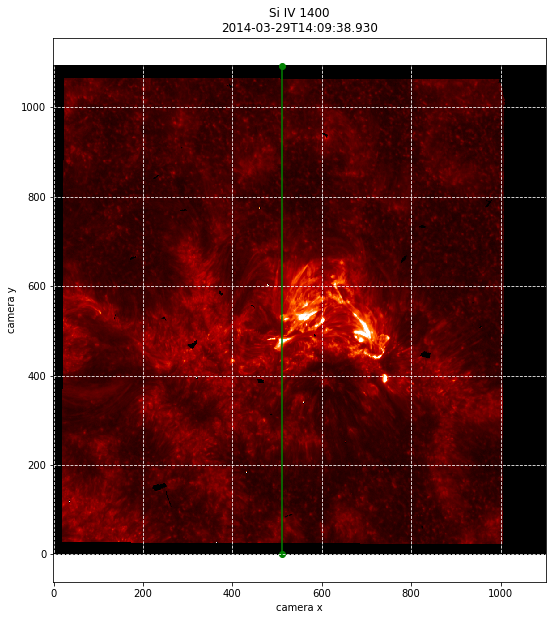

In [4]:
import matplotlib.pyplot as plt

plt.figure( figsize=(10,10) )
slitpos = sji.get_slit_pos(0)
ymax = sji.shape[1]-1
sji.plot( 0, grid=True )
plt.scatter( slitpos, 0, c="green" )
plt.scatter( slitpos, ymax, c="green" )
plt.plot( [slitpos,slitpos], [0,ymax], c="green" )

Works!

## Part 3: Plot a Line on the Slit in Coordinate Space

When choosing units="coordinates", `sji.plot()` plots in solar coordinates. Subsequent plots with `plt.plot()` or `plt.scatter()` will still be in pixel coordinates, unless a transform is used. For convenience, a transform function is supplied in `irisreader.utils.coordinates`. **First, the line is given in terms of pixel coordinates**

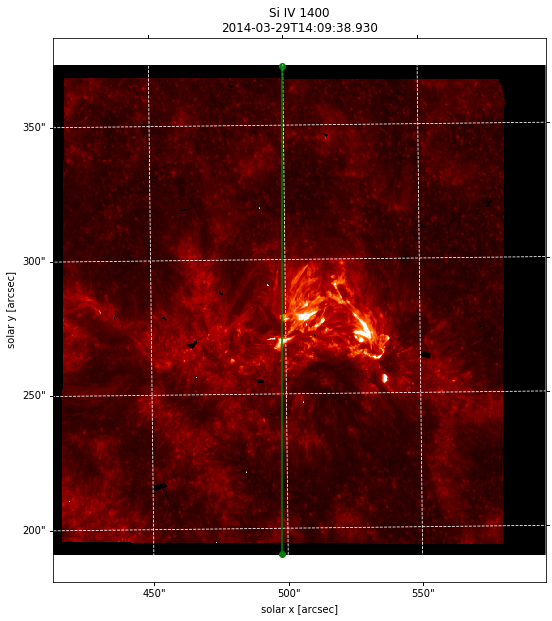

In [5]:
plt.figure( figsize=(10,10) )
sji.plot( 0, units="coordinates", grid=True )
plt.plot( [slitpos,slitpos], [0,ymax], c="green" )
plt.scatter( slitpos, 0, c="green" )
plt.scatter( slitpos, ymax, c="green" )

When we have **line endpoints given in solar coordinates**, we can use a transform supplied by irisreader:

In [7]:
# compute line endpoints in solar coordinates
import numpy as np
lower_point = sji.pix2coords( 0, np.array([slitpos,0]) )
upper_point = sji.pix2coords( 0, np.array([slitpos,ymax]) )
lower_point, upper_point

(array([497.53946557, 190.11448504]), array([499.58927071, 371.932975  ]))

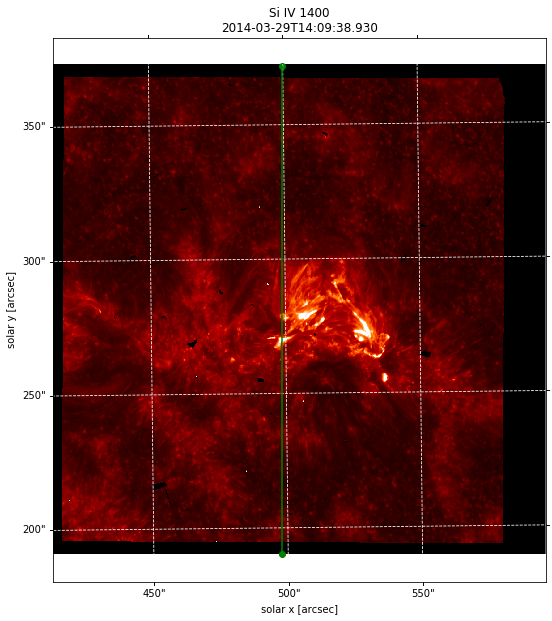

In [8]:
# plot line with endpoints given in solar coordinates
from irisreader.utils.coordinates import get_ax_transform
plt.figure( figsize=(10,10) )
sji.plot(0, units="coordinates", grid=True )
plt.scatter( lower_point[0], lower_point[1], c="green", transform=get_ax_transform() )
plt.scatter( upper_point[0], upper_point[1], c="green", transform=get_ax_transform() )
plt.plot( [lower_point[0], upper_point[0]], [lower_point[1],upper_point[1]], c="green", transform=get_ax_transform() )

## Part 4: Applying PZT Correction

To compute the position of the observed raster on the SJI, one needs to take into account secondary mirror corrections driven by piezoelectric (PZT) transducers.

First, let's get the coordinates of the slit in pixels:

In [9]:
step = 0
y_min = 0
y_max = sji.shape[1] - 1
slitcoord_down = sji.pix2coords( step, np.array([sji.get_slit_pos(step), y_min]) )
slitcoord_up = sji.pix2coords( step, np.array([sji.get_slit_pos(step), y_max]) )
slitcoord_down, slitcoord_up

(array([497.53946557, 190.11448504]), array([499.58927071, 371.932975  ]))

Let's plot:

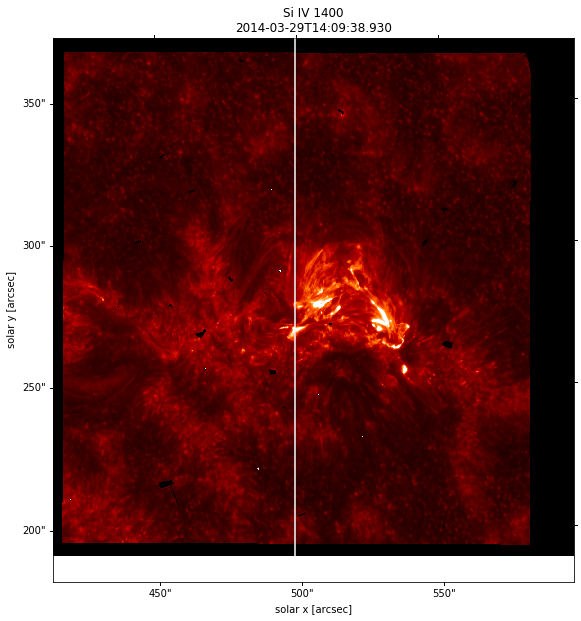

In [10]:
from irisreader.utils.coordinates import get_ax_transform
plt.figure( figsize=(10,10) )
sji.plot( step, units="coordinates" )
plt.plot( 
    [slitcoord_down[0], slitcoord_up[0]], [slitcoord_down[1], slitcoord_up[1]], 
    transform=get_ax_transform(), c="white" 
) 

This fits more or less perfectly on the shadow of the slit. However the secondary mirror might get spectra from somewhere else. To get information about the position of the secondary mirror, we also need to access the corresponding raster:

In [12]:
raster = obs.raster("Mg II k")
raster.headers[0]['PZTX']

-7.294394016265869

Let's define a function that computes the corrected coordinates:

In [13]:
def pzt_coordinate( coord, step, sji, raster ):
    return slitcoord_down[0] - sji.headers[step]['PZTX'] + raster.headers[step]['PZTX']

Apply it:

In [14]:
# get upper and lower boundaries of the slit in order to draw a line
slitcoord_down = sji.pix2coords( step, np.array([sji.get_slit_pos(step), y_min]) )
slitcoord_up = sji.pix2coords( step, np.array([sji.get_slit_pos(step), y_max]) )
    
# apply PZT secondary mirror correction
slitcoord_down[0] = pzt_coordinate( slitcoord_down[0], step, sji, raster )
slitcoord_up[0] = pzt_coordinate( slitcoord_up[0], step, sji, raster )

Plot the actual position where the raster are from in the first exposure:

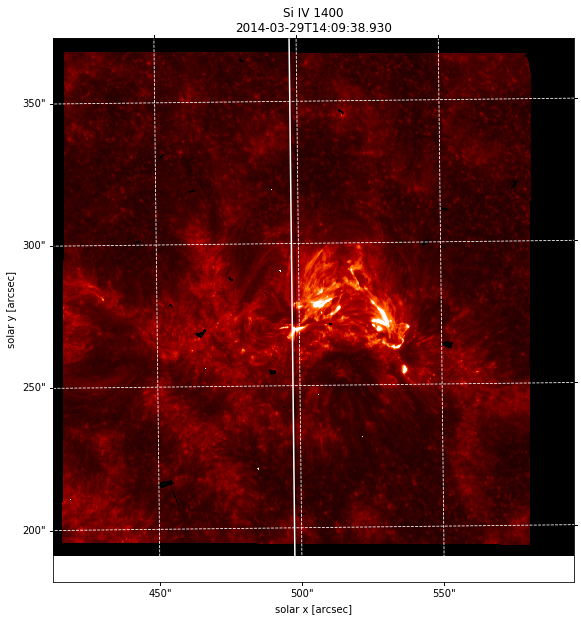

In [15]:
from irisreader.utils.coordinates import get_ax_transform
plt.figure( figsize=(10,10) )
sji.plot( step, units="coordinates", grid=True )
plt.plot( 
    [slitcoord_down[0], slitcoord_up[0]], [slitcoord_down[1], slitcoord_up[1]], 
    transform=get_ax_transform(), c="white" 
) 

Let's animate this to understand better how the secondary mirror works. To this end it's more convenient to implement what the `sji.plot()` function does ourselves.

In [16]:
def get_slit_reference( sji, step ):
    ymin = 0
    ymax = sji.shape[1]-1
    
    # get upper and lower boundaries of the slit in order to draw a line
    slitcoord_down = sji.pix2coords( step, np.array([sji.get_slit_pos(step), ymin]) )
    slitcoord_up = sji.pix2coords( step, np.array([sji.get_slit_pos(step), ymax]) )
    
    # apply PZT secondary mirror correction
    slitcoord_down[0] = pzt_coordinate( slitcoord_down[0], step, sji, raster )
    slitcoord_up[0] = pzt_coordinate( slitcoord_up[0], step, sji, raster )
    
    return [slitcoord_down, slitcoord_up]

In [17]:
from matplotlib import animation

gamma = 0.3
cutoff_percentile = 99.9

fig = plt.figure( figsize=(10,10) )
plt.subplot( projection=sji._ico.wcs.celestial ) # ok this part is from under the hood..
image = sji.get_image_step( 0 ).clip(min=0.01)**gamma
vmax = np.percentile( image, cutoff_percentile )
im = plt.imshow( image, cmap="gist_heat", vmax=vmax, origin='lower' )
slitcoord_down, slitcoord_up = get_slit_reference( sji, 0 )
line, = plt.plot( 
    [slitcoord_down[0], slitcoord_up[0]], [slitcoord_down[1], slitcoord_up[1]], 
    transform=get_ax_transform(), c="white" 
)
plt.grid(color='white', ls='--')
plt.close( fig )

# do nothing in the initialization function
def init():
    return im,

# animation function
def animate(i):
    xcenix = sji.headers[i]['XCENIX']
    ycenix = sji.headers[i]['YCENIX']
    date_obs = sji.headers[i]['DATE_OBS']
    im.axes.set_title( "Frame {}: {}\nXCENIX: {:.3f}, YCENIX: {:.3f}".format( i, date_obs, xcenix, ycenix ) )
    im.set_data( sji.get_image_step( i ).clip(min=0.01)**gamma )
    slitcoord_down, slitcoord_up = get_slit_reference( sji, i )
    line.set_xdata( [slitcoord_down[0], slitcoord_up[0]] )
    line.set_ydata( [slitcoord_down[1], slitcoord_up[1]] )
    return im,

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(
    fig, lambda i: animate(i), init_func=init, frames=sji.shape[0],
    interval=50, blit=True
)    

from IPython.display import HTML
HTML(anim.to_html5_video())